# Logistic Regression

## Load Dataset from sklearn

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()



In [37]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


### Select features

In [38]:
cols = ["mean radius", "mean texture",
        "mean smoothness", "mean compactness", "mean concave points",
        "worst radius", "worst texture",
        "worst smoothness", "worst compactness", "worst concave points",
        "class"]

## Train Model with PyTorch

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [40]:
data = torch.from_numpy(df[cols].values).float()

data.shape

torch.Size([569, 11])

In [41]:
# Split x and y.
x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


In [102]:
# Define configurations.
n_epochs = 10000
learning_rate = 1e-2
print_interval = 1000

In [103]:
# Define costum model.
class MyModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        super().__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, x):
        # |x| = (batch_size, input_dim)
        y = self.act(self.linear(x))
        # |y| = (batch_size, output_dim)

        return y

In [104]:
model = MyModel(input_dim=x.size(-1),
                output_dim=y.size(-1))
crit = nn.BCELoss() # Define BCELoss instead of MSELoss.

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

In [110]:
for i in range(n_epochs):
    y_hat = model(x)
    loss = crit(y_hat, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, loss))

Epoch 1000: loss=2.6938e-01
Epoch 2000: loss=2.6361e-01
Epoch 3000: loss=2.5819e-01
Epoch 4000: loss=2.5308e-01
Epoch 5000: loss=2.4825e-01
Epoch 6000: loss=2.4369e-01
Epoch 7000: loss=2.3937e-01
Epoch 8000: loss=2.3527e-01
Epoch 9000: loss=2.3139e-01
Epoch 10000: loss=2.2769e-01


## Let's see the result!

In [166]:
def perf_measure(y_actual, y_pred,thres):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):

        if (y_pred[i]>=thres):  y_tmp=1.0
        else:  y_tmp=0.0

        if y_actual[i]==y_tmp==1.0:
           TP += 1
        if y_tmp==1.0 and y_actual[i]!=y_tmp:
           FP += 1
        if y_actual[i]==y_tmp==0.0:
           TN += 1
        if y_tmp==0.0 and y_actual[i]!=y_tmp:
           FN += 1

    return (TP, FP, TN, FN)

In [181]:

thres=0.9
correct_cnt = (y == (y_hat > thres)).sum()

total_cnt = float(y.size(0))
print('Accuracy: %.4f' % (correct_cnt / total_cnt))
(tp,fp,tn,fn)=perf_measure(y,y_hat,thres)
print(tp,tn,fp,fn)
acc=(tp+tn)/(tp+fp+tn+fn)
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1=2*(recall*precision)/(recall+precision)
print('acc precision recall f1',acc,precision, recall, f1)
#for i in range(len(y_hat)):
#  print(' %.3f' % y_hat[i])

Accuracy: 0.6731
174 209 3 183
acc precision recall f1 0.6731107205623902 0.9830508474576272 0.48739495798319327 0.651685393258427


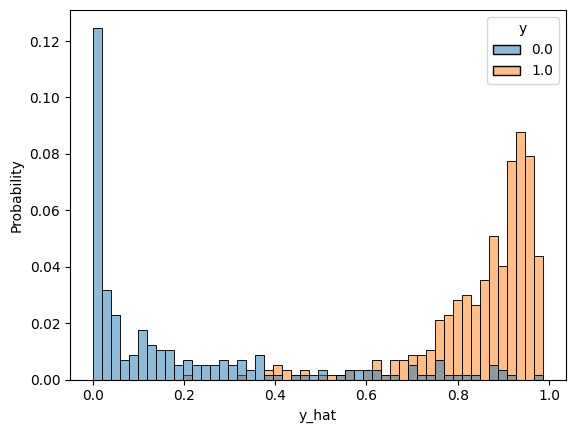

In [182]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()